## Задача классификации непрерывных команд от пользователя на основе данных, полученных от оптомиографических датчиков

Необходимо построить модель распознавания жестов в парадигме обучения с учителем. Параметры модели должны быть оптимизированы на предложенных данных для обучения. Валидация модели будет произведена на отложенной тестовой выборке.

<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:blue; border:0; color:white' role="tab" aria-controls="home"><center>Quick navigation</center></h2>

* [0. Installation of libraries](#0)
* [1. Basic Data Overview](#1)
* [2. Preparation of data](#2)
* [3. Predicting models](#3)
* [4. Optimization of hyperparameters](#4)
* [5. Prediction of movements in test data](#5)

<a id="0"></a>
<h2 style='background:blue; border:0; color:white'><center>0. 🛠 Installation of libraries</center><h2>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
import plotly 
import plotly.express as px

from  sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

<a id="1"></a>
<h2 style='background:blue; border:0; color:white'><center>1. 📚 Basic Data Overview</center><h2>

In [2]:
X_train = np.load('/kaggle/input/motorica-skillfactory-internship-test-task-2023-12/X_train.npy')
display('X_train:',X_train.shape)

X_test = np.load('/kaggle/input/motorica-skillfactory-internship-test-task-2023-12/X_test.npy')
display('X_test:',X_test.shape)

'X_train:'

(323, 40, 100)

'X_test:'

(54, 40, 100)

`y_train.csv` содержит следующие классы: 
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

In [3]:
y_train_df = pd.read_csv('/kaggle/input/motorica-skillfactory-internship-test-task-2023-12/y_train.csv')
display('y_train:',y_train_df.shape)
display(y_train_df.head())

'y_train:'

(32300, 2)

,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0


In [4]:
y_train = y_train_df.copy()
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', n=1, expand=True).astype(int)
display(y_train.head(3))
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
display(y_train)
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

print(y_train.shape)
y_train

,sample-timestep,class,sample_id,timestep
0,0-0,0,0,0
1,0-1,0,0,1
2,0-2,0,0,2


timestep,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
sample_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,0,0,0,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8
319,8,8,8,8,8,8,8,8,8,8,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7


(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]])

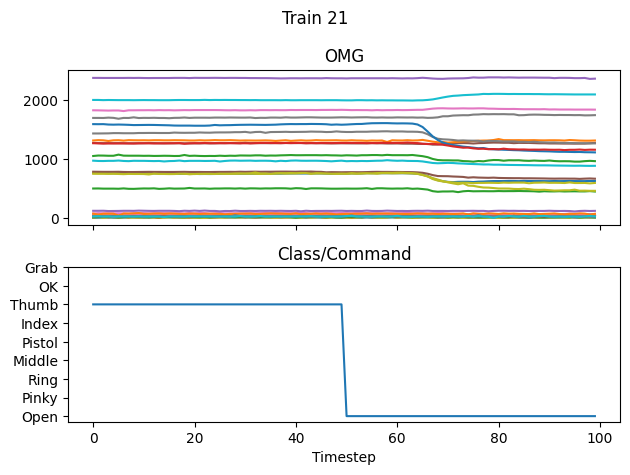

In [5]:
i = 21
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

,sample_id,class,count
0,0,Open,100
1,1,Open,100
2,2,Open,50
3,2,Thumb,50
4,3,Open,50


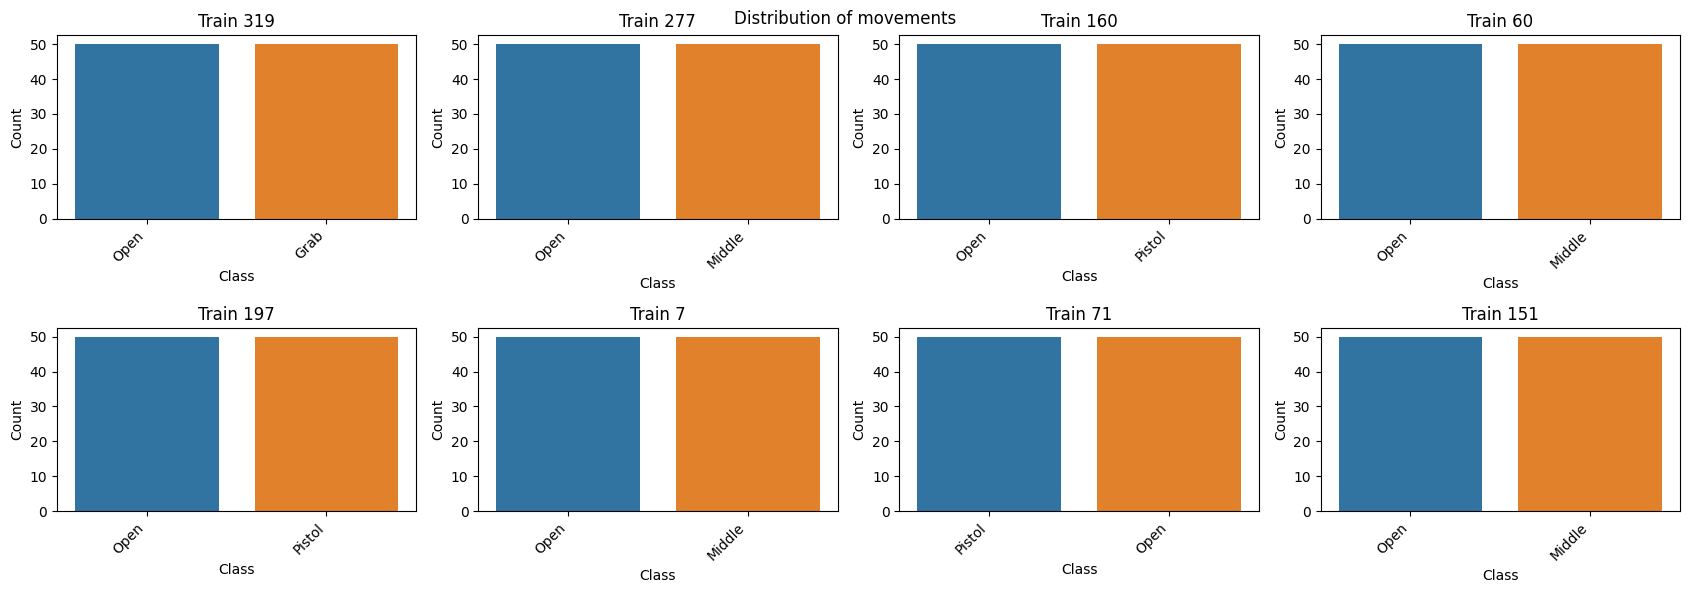

In [6]:
y_train = y_train_df.copy()
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', n=1, expand=True).astype(int)
temp = y_train.groupby('sample_id', as_index=False)['class'].value_counts()
dic = {0:'Open',1: 'Pinky', 2:'Ring', 3:'Middle',
       4:'Pistol', 5:'Index',6: 'Thumb',7: 'OK',8: 'Grab'}
temp['class'] = temp['class'].map(dic)
display(temp.head())
samples = temp.sample_id.unique()
figs = []
fig, axes = plt.subplots(2, 4, figsize=(17, 6))

# Iterate over samples and create bar plots
for i, sample_id in enumerate(np.random.choice(samples, 8, replace=False)):
    temp_sample = temp[temp['sample_id'] == sample_id]
    
    # Calculate the position in the 2x4 grid
    row, col = divmod(i-1, 4)
    
    sns.barplot(x='class', y='count', data=temp_sample, ax=axes[row, col])

    axes[row, col].set_title(f'Train {sample_id}')
    axes[row, col].set_xlabel('Class')
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_xticks(np.arange(len(temp_sample['class'])))
    axes[row, col].set_xticklabels(labels=temp_sample['class'], rotation=45, ha='right')
                            
plt.tight_layout()
fig.suptitle('Distribution of movements')
plt.show()

<a id="2"></a>
<h2 style='background:blue; border:0; color:white'><center>2. 🗂 Preparation of data </center><h2>

For a sequence classification problem where you want to predict a class for each time step,bthe shapes of X_train and y_train should be as follows:
 - X_train: (number_of_samples, n_timesteps,n_features)
 - y_train: (number_of_samples, n_timesteps,n_classes)

In [7]:
from keras.utils import to_categorical
n_timesteps=100
n_features=40
n_classes=9

X_train = np.load('/kaggle/input/motorica-skillfactory-internship-test-task-2023-12/X_train.npy')
X_train = X_train.reshape((X_train.shape[0], n_timesteps, n_features))

y_train = y_train_df.copy()
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', n=1, expand=True).astype(int)
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

y_train_encoded = to_categorical(y_train)
# Reshape y_train_encoded to have 100 time steps
y_train = y_train_encoded.reshape((y_train_encoded.shape[0], n_timesteps, n_classes,))

print(X_train.shape,
      y_train.shape)

(323, 100, 40) (323, 100, 9)


In [8]:
# split on training and valid ds
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Reshape X_train to (number_of_samples * 100, 40) before scaling
X_train_reshaped = X_train.reshape(-1, 40)
# Fit and transform the training data
X_train_norm_reshaped = scaler.fit_transform(X_train_reshaped)
# Reshape it back to the original shape
X_train_norm = X_train_norm_reshaped.reshape(X_train.shape)

# Reshape X_test to (number_of_samples * 100, 40) before scaling
X_valid_reshaped = X_valid.reshape(-1, 40)
# Transform the test data using the same scaler
X_valid_norm_reshaped = scaler.transform(X_valid_reshaped)
# Reshape it back to the original shape
X_valid_norm = X_valid_norm_reshaped.reshape(X_valid.shape)

display('X_train:',X_train_norm.shape, 
        'X_test:', X_valid_norm.shape,
       
       'y_train:', y_train.shape)


'X_train:'

(258, 100, 40)

'X_test:'

(65, 100, 40)

'y_train:'

(258, 100, 9)

<a id="3"></a>
<h2 style='background:blue; border:0; color:white'><center>3. 💻 Predicting models </center><h2>

Metric for modeling - Mean F-score

In [10]:
#Plot for accuracy and val_loss
def plot_accur(history, epochs=20):
    acc = history.history['f1_score']
    val_acc = history.history['val_f1_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Mean F-score')
    plt.plot(epochs_range, val_acc, label='Validation Mean F-score')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Mean F-score')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [11]:
def f1_score(y_true, y_pred):
    # Function to calculate F-score
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

The first experiments on basic models showed 56% accuracy and 53% val_accyracy.

Things to consider:
 - complexity of models
 - reducing the learning rate
 - Add regularization techniques such as dropout or L1/L2 regularization
 - Balance your classes or use techniques like class weights.

# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization
from keras.layers import TimeDistributed
from keras.optimizers import Adam
from keras.layers import Dropout
# Bidirectional layers can allow the model to learn from both past and future time steps.
from keras.layers import Bidirectional
from keras.regularizers import l1
from keras.layers import GRU
from keras import backend as K 

model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(100, return_sequences=True), 
                             input_shape=(n_timesteps, n_features)))
model_lstm.add(BatchNormalization())
model_lstm.add(Bidirectional(LSTM(100, return_sequences=True)))
model_lstm.add(BatchNormalization())
model_lstm.add(Bidirectional(LSTM(50, return_sequences=True)))
model_lstm.add(BatchNormalization())
model_lstm.add(Bidirectional(LSTM(50, return_sequences=True)))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(TimeDistributed(Dense(n_classes, activation='softmax')))
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(loss='categorical_crossentropy', 
                   optimizer=optimizer, 
                   metrics=[f1_score])
history_lstm = model_lstm.fit(X_train_norm, 
                    y_train, 
                    epochs=40, 
                    batch_size=32, 
                    validation_data=(X_valid_norm, y_valid))
plot_accur(history_lstm, epochs=40)

K.clear_session()

Epoch 1/40
9/9 [==============================] - 30s 965ms/step - loss: 2.5957 - f1_score: 0.0693 - val_loss: 2.2178 - val_f1_score: 0.0000e+00
Epoch 2/40
9/9 [==============================] - 4s 433ms/step - loss: 2.0605 - f1_score: 0.1636 - val_loss: 2.1911 - val_f1_score: 0.0000e+00
Epoch 3/40
9/9 [==============================] - 4s 432ms/step - loss: 1.8131 - f1_score: 0.2657 - val_loss: 2.2080 - val_f1_score: 0.0000e+00
Epoch 4/40
9/9 [==============================] - 4s 457ms/step - loss: 1.5427 - f1_score: 0.4436 - val_loss: 2.2530 - val_f1_score: 0.0000e+00
Epoch 5/40
9/9 [==============================] - 4s 428ms/step - loss: 1.3372 - f1_score: 0.5154 - val_loss: 2.2700 - val_f1_score: 0.0000e+00
Epoch 6/40
9/9 [==============================] - 4s 447ms/step - loss: 1.1890 - f1_score: 0.6239 - val_loss: 2.1967 - val_f1_score: 0.0000e+00
Epoch 7/40
9/9 [==============================] - 4s 489ms/step - loss: 0.9940 - f1_score: 0.6664 - val_loss: 2.2119 - val_f1_score: 0.

# Gated Recurrent Unit (GRU) 

Epoch 1/40
9/9 [==============================] - 28s 780ms/step - loss: 13.3178 - f1_score: 0.0257 - val_loss: 6.9106 - val_f1_score: 0.0000e+00
Epoch 2/40
9/9 [==============================] - 4s 393ms/step - loss: 5.7195 - f1_score: 0.1502 - val_loss: 4.6733 - val_f1_score: 0.0000e+00
Epoch 3/40
9/9 [==============================] - 3s 325ms/step - loss: 3.8120 - f1_score: 0.4450 - val_loss: 3.2347 - val_f1_score: 0.2920
Epoch 4/40
9/9 [==============================] - 3s 335ms/step - loss: 2.9567 - f1_score: 0.4993 - val_loss: 2.9588 - val_f1_score: 0.5256
Epoch 5/40
9/9 [==============================] - 3s 364ms/step - loss: 2.6065 - f1_score: 0.5053 - val_loss: 2.5883 - val_f1_score: 0.5155
Epoch 6/40
9/9 [==============================] - 3s 345ms/step - loss: 2.3014 - f1_score: 0.4603 - val_loss: 2.4206 - val_f1_score: 0.3420
Epoch 7/40
9/9 [==============================] - 3s 345ms/step - loss: 2.2822 - f1_score: 0.4770 - val_loss: 2.5810 - val_f1_score: 0.3781
Epoch 8/40

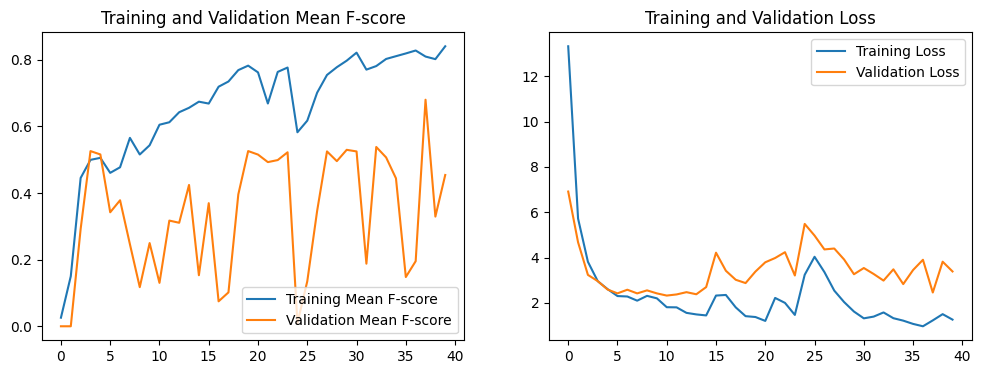

In [14]:
model_gru = Sequential()
model_gru.add(Bidirectional(GRU(100, return_sequences=True,
                            kernel_regularizer=l1(0.01)), 
                        input_shape=(n_timesteps, n_features)
                       ))
model_gru.add(BatchNormalization())
model_gru.add(Bidirectional(GRU(50, return_sequences=True)))
model_gru.add(BatchNormalization())
model_gru.add(Bidirectional(GRU(50, return_sequences=True)))
model_gru.add(BatchNormalization())
model_gru.add(Bidirectional(GRU(25, return_sequences=True)))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(TimeDistributed(Dense(n_classes, activation='softmax')))
optimizer = Adam(learning_rate=0.01)
model_gru.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[f1_score])
history_gru = model_gru.fit(X_train_norm, 
                    y_train, 
                    epochs=40, 
                    batch_size=32, 
                    validation_data=(X_valid_norm, y_valid))
plot_accur(history_gru, epochs=40)


<a id="4"></a>
<h2 style='background:blue; border:0; color:white'><center>4. 🔎 Optimization of hyperparameters </center><h2>

In [ ]:
#pip install keras scikit-learn

In [ ]:
#pip install scikeras

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, BatchNormalization, Dropout, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, n_timesteps, n_features, n_classes, 
                 units1=100, units2=50, units3=50,
                 l1_reg=0.01, dropout=0.2, learning_rate=0.001, 
                 epochs=10, batch_size=32, verbose=0):
        self.n_timesteps = n_timesteps
        self.n_features = n_features
        self.n_classes = n_classes
        self.units1 = units1
        self.units2 = units2
        self.units3 = units3
        self.l1_reg = l1_reg
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Bidirectional(GRU(self.units1, return_sequences=True, kernel_regularizer=l1(self.l1_reg)),
                                input_shape=(self.n_timesteps, self.n_features)))
        model.add(BatchNormalization())
        model.add(Bidirectional(GRU(self.units2, return_sequences=True)))
        model.add(BatchNormalization())
        model.add(Bidirectional(GRU(self.units3, return_sequences=True)))
        model.add(BatchNormalization())
        model.add(Dropout(self.dropout))
        model.add(TimeDistributed(Dense(self.n_classes, activation='softmax')))
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(loss='categorical_crossentropy', 
                      optimizer=optimizer, 
                      metrics=[f1_score])
        return model

    def fit(self, X, y, validation_data=None):
        history = self.model.fit(X, y, 
                                 epochs=self.epochs, 
                                 batch_size=self.batch_size, 
                                 verbose=self.verbose,
                                validation_data=(X_valid, y_valid))
        return history

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.utils import to_categorical

# Define the hyperparameter search space
param_dist = {
    'units1': randint(50, 200),
    'units2': randint(0,50),
    'units3': randint(0,50),
    'l1_reg': [0.0, 0.01, 0.1],  # L1 regularization parameter
    'dropout': [0.2, 0.3, 0.4],  # Dropout rate
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate
    'epochs': randint(10,50)
}

# Create an instance of KerasClassifierWrapper
wrapper = KerasClassifierWrapper(n_timesteps, n_features, n_classes)

# Use RandomizedSearchCV for hyperparameter search
random_search = RandomizedSearchCV(estimator=wrapper, 
                                   param_distributions=param_dist, 
                                   n_iter=10, 
                                   cv=3, 
                                   verbose=2)

random_search.fit(X_train_norm, y_train,
                 validation_data=(X_valid_norm, y_valid))

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
3/3 [==============================] - 3s 62ms/step
[CV] END dropout=0.4, epochs=48, l1_reg=0.0, learning_rate=0.001, units1=126, units2=14, units3=48; total time= 1.8min
3/3 [==============================] - 3s 60ms/step
[CV] END dropout=0.4, epochs=48, l1_reg=0.0, learning_rate=0.001, units1=126, units2=14, units3=48; total time= 1.8min
3/3 [==============================] - 3s 64ms/step
[CV] END dropout=0.4, epochs=33, l1_reg=0.1, learning_rate=0.1, units1=179, units2=24, units3=31; total time= 1.3min
3/3 [==============================] - 3s 59ms/step
[CV] END dropout=0.4, epochs=33, l1_reg=0.1, learning_rate=0.1, units1=179, units2=24, units3=31; total time= 1.7min
3/3 [==============================] - 3s 58ms/step
[CV] END dropout=0.4, epochs=33, l1_reg=0.1, learning_rate=0.1, units1=179, units2=24, units3=31; total time= 1.7min
3/3 [==============================] - 3s 59ms/step
[CV] END dropout=0.4, epochs=28, l1_re

In [16]:
#Best Hyperparameters: {'dropout': 0.4, 'epochs': 47, 'l1_reg': 0.1, 'learning_rate': 0.01, 'units1': 96, 'units2': 6, 'units3': 37}
best_model = KerasClassifierWrapper(n_timesteps, n_features, n_classes, **best_params)
history_bm = best_model.fit(X_train_norm, y_train,
                        validation_data=(X_valid_norm, y_valid))

NameError: name 'best_params' is not defined

In [ ]:
# Access training and validation accuracy and loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the accuracy and loss curves
plot_accur(history, epochs=len(training_accuracy))

<a id="5"></a>
<h2 style='background:blue; border:0; color:white'><center>5. 🔮 Prediction of movements in test data </center><h2>

In [ ]:
#For a sequence classification problem
# where you want to predict a class for each time step, 
# the shapes of X_train and y_train should be as follows:
# X_train: (number_of_samples, n_timesteps,n_features)
# y_train: (number_of_samples, n_timesteps,n_classes)
from keras.utils import to_categorical
n_timesteps=100
n_features=40
n_classes=9

X_test = np.load('/kaggle/input/motorica-skillfactory-internship-test-task-2023-12/X_test.npy')
X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))

print(X_test.shape)

In [ ]:
predictions = model_lstm.predict(X_test)
print(predictions.shape)

In [ ]:
flat_predictions = predictions.reshape(-1, n_classes)
flat_indices = np.array([[f"{i}-{j}" for j in range(n_timesteps)] for i in range(predictions.shape[0])]).reshape(-1)

# Create a DataFrame
df_predictions = pd.DataFrame(data=flat_predictions, columns=[f"class_{i}" for i in range(n_classes)])

# Add "sample-timestep" column
df_predictions["sample-timestep"] = flat_indices

# Reorder columns
df_predictions = df_predictions[["sample-timestep"] + [f"class_{i}" for i in range(n_classes)]]

# Melt the DataFrame to have only two columns
df_predictions = pd.melt(df_predictions, id_vars=["sample-timestep"], var_name="class", value_name="probability")

(df_predictions.head())

In [ ]:
submission = df_predictions.drop('probability', axis=1)
submission.to_csv('/kaggle/working/sample_submission.csv')